# Question 1: Machine Learning

Describe your preferred approach for using machine learning to predict passenger survival using the Spaceship Titanic
dataset provided. Outline the necessary steps you would take to build and refine a model of your choice (eg. exploring the data, preparing it for analysis, dividing it into training and testing sets, checking for unusual data points, balancing minority classes, choosing important features, and fine-tuning the model with grid search). Assess the model's effectiveness using accuracy. Please provide a clear explanation of each step you have chosen. The information about the features can be found here: https://www.kaggle.com/competitions/spaceship-titanic/data


## EDA and Feature Engineering

In [378]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [379]:
titanic = pd.read_csv('spaceship_titanic.csv')
titanic.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [380]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [381]:
df = titanic.copy()
X = df.drop(['Transported'], axis=1)
y = df['Transported']

### Train Test Split

To avoid data leakage, train-test split needs to be performed before feature engineering.

In [382]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Check and Deal with Missing Values

In the next step, we check for and deal with missing values in each feature.

In [383]:
print(f'The number of rows with at least one missing value is {sum(X_train.isnull().sum(axis=1)>0)}')

The number of rows with at least one missing value is 1647


Due to the large number of missing values, we need to impute them as much as possible.

Finding 1: When the first part of the PassengerId is same, the Homeplanet and Cabin are also same. This can be used to fill in some missing values for Homeplanet and Cabin.

Reference: https://www.kaggle.com/competitions/spaceship-titanic/discussion/310574

In [384]:
# create a new column to help with imputation
X_train['PassengerId1'] = X_train["PassengerId"].str.split("_", expand=True)[0]
X_test['PassengerId1'] = X_test["PassengerId"].str.split("_", expand=True)[0]

In [385]:
# define a helper function for filling missing values
def fill_missing(df, row, variable):
    imputed = df[df['PassengerId1']==df.loc[row, 'PassengerId1']][variable].unique()
    imputed = [x for x in imputed if x==x]
    if len(imputed)==1:
        df.loc[row, variable] = imputed[0]

In [386]:
# fill HomePlanet in training set
HomePlanet_null = X_train[X_train['HomePlanet'].isnull()].index.tolist()
for i in HomePlanet_null:
    fill_missing(X_train, i, 'HomePlanet')

In [387]:
# fill HomePlanet in test set
HomePlanet_null = X_test[X_test['HomePlanet'].isnull()].index.tolist()
for i in HomePlanet_null:
    fill_missing(X_test, i, 'HomePlanet')

In [388]:
# fill Cabin in training set
Cabin_null = X_train[X_train['Cabin'].isnull()].index.tolist()
for i in Cabin_null:
    fill_missing(X_train, i, 'Cabin')

In [389]:
# fill Cabin in test set
Cabin_null = X_test[X_test['Cabin'].isnull()].index.tolist()
for i in Cabin_null:
    fill_missing(X_test, i, 'Cabin')

Finding 2: People with more spending are more likely to have paid for special VIP service and those who have no spending are more likely to have CryoSleep=True.

In [390]:
# create a new column to help with imputation
X_train['TotalSpending'] = X_train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
X_test['TotalSpending'] = X_test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

In [391]:
X_train.groupby('VIP')['TotalSpending'].aggregate(['min', 'max', 'mean'])

,min,max,mean
VIP,,,
False,0.0,30478.0,1382.627336
True,0.0,31074.0,4381.000000


In [392]:
# define a helper function for filling missing values
def fill_missing2(df, row, variable, threshold, imputed):
    if df.loc[row, 'TotalSpending']>threshold:
        df.loc[row, variable] = imputed
    else:
        df.loc[row, variable] = not imputed

In [393]:
# fill VIP
VIP_threshold = X_train.groupby('VIP')['TotalSpending'].mean()[1]
VIP_null = X_train[X_train['VIP'].isnull()].index.tolist()
for i in VIP_null:
    fill_missing2(X_train, i, 'VIP', VIP_threshold, True)
    
VIP_null = X_test[X_test['VIP'].isnull()].index.tolist()
for i in VIP_null:
    fill_missing2(X_test, i, 'VIP', VIP_threshold, True)

In [394]:
X_train.groupby('CryoSleep')['TotalSpending'].aggregate(['min', 'max', 'mean'])

,min,max,mean
CryoSleep,,,
False,0.0,31074.0,2238.614348
True,0.0,0.0,0.000000


In [395]:
# fill CryoSleep
CryoSleep_threshold = 0
CryoSleep_null = X_train[X_train['CryoSleep'].isnull()].index.tolist()
for i in CryoSleep_null:
    fill_missing2(X_train, i, 'CryoSleep', CryoSleep_threshold, False)

CryoSleep_null = X_test[X_test['CryoSleep'].isnull()].index.tolist()
for i in CryoSleep_null:
    fill_missing2(X_test, i, 'CryoSleep', CryoSleep_threshold, False)

Finding 3: As the distribution of Age follows a normal distribution, we can use its mean to populate the missing values. 

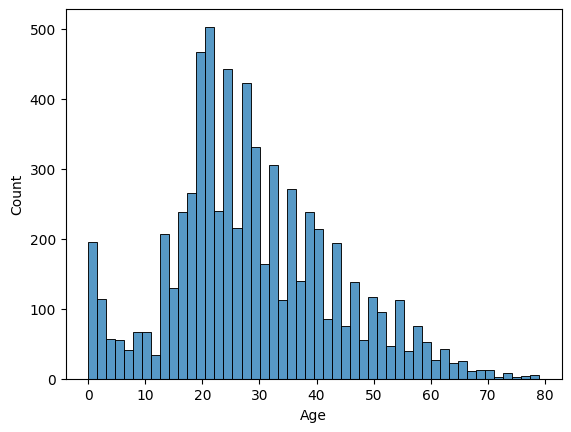

In [396]:
sns.histplot(X_train['Age'], bins=50)
plt.show()

In [397]:
# fill Age
X_train['Age'] = X_train['Age'].fillna(X_train['Age'].mean())
X_test['Age'] = X_test['Age'].fillna(X_train['Age'].mean())

Finding 4: For the rest of features, we may use the value that appears the most to populate the missing values.

In [398]:
# fill other missing values
missing_features = ['HomePlanet', 'Cabin', 'Destination',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for feature in missing_features:
    fill = X_train[feature].value_counts().index[0]
    X_train[feature] = X_train[feature].fillna(fill)
    X_test[feature] = X_test[feature].fillna(fill)

### Expand Cabin

Cabin is compose of 3 parts of information, so needs to be split before further analysis.

In [399]:
# split Cabin
X_train[["Deck", "Cabin_num", "Side"]] = X_train["Cabin"].str.split("/", expand=True)
X_test[["Deck", "Cabin_num", "Side"]] = X_test["Cabin"].str.split("/", expand=True)

### Convert Categorical and Boolean Features into Numerical Features

Categorical and boolean features need to be converted to numberical features before being used for model building.

In [400]:
# convert categorical features
features_cat = ['HomePlanet', 'Destination', 'Deck', 'Side']
for feature in features_cat:
    X_train[pd.get_dummies(X_train[feature], prefix=feature).columns] = pd.get_dummies(X_train[feature], prefix=feature)
    X_test[pd.get_dummies(X_test[feature], prefix=feature).columns] = pd.get_dummies(X_test[feature], prefix=feature)

In [401]:
# Deck_T is missing in the test set, so needs to be added
X_test.insert(loc = list(X_train.columns).index('Deck_T'),
          column = 'Deck_T',
          value = pd.Series([0]*len(X_test)))

In [421]:
# convert boolean features
features_boolean = ['CryoSleep', 'VIP', 'Cabin_num']
for feature in features_boolean:
    X_train[feature] = X_train[feature].astype(int)
    X_test[feature] = X_test[feature].astype(int)

In [403]:
# bin Age into groups
def age_group(s):
    return s//10
X_train['Age_group'] = X_train['Age'].apply(age_group)
X_test['Age_group'] = X_test['Age'].apply(age_group)

### Drop Irrelevant Features

PassengerId and Name are not meaningful for predicting passenger survival, and thus can be dropped, together with other irrelevant features.

In [404]:
# drop features for training set
X_train = X_train.drop(['PassengerId', 'PassengerId1', 'Name', 'TotalSpending', 'Cabin', 
                        'HomePlanet', 'Destination', 'Deck', 'Side'], axis=1)
X_train.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_num,HomePlanet_Earth,...,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,Age_group
0,0,28.0,0,0.0,55.0,0.0,656.0,0.0,981,1,...,0,0,0,0,0,1,0,0,1,2.0
1,0,17.0,0,0.0,1195.0,31.0,0.0,0.0,575,1,...,0,0,0,0,1,0,0,1,0,1.0
2,1,28.0,0,0.0,0.0,0.0,0.0,0.0,329,0,...,0,1,0,0,0,0,0,0,1,2.0
3,0,20.0,0,0.0,2.0,289.0,976.0,0.0,1800,0,...,0,0,0,0,1,0,0,1,0,2.0
4,1,36.0,0,0.0,0.0,0.0,0.0,0.0,18,0,...,0,1,0,0,0,0,0,1,0,3.0


In [405]:
# drop features for test set
X_test = X_test.drop(['PassengerId', 'PassengerId1', 'Name', 'TotalSpending', 'Cabin', 
                      'HomePlanet', 'Destination', 'Deck', 'Side'], axis=1)
X_test.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_num,HomePlanet_Earth,...,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,Age_group
0,0,19.0,0,417.0,349.0,634.0,3.0,1057.0,63,0,...,0,0,0,0,1,0,0,0,1,1.0
1,0,18.0,0,4.0,904.0,0.0,0.0,1.0,460,1,...,0,0,0,0,0,1,0,0,1,1.0
2,1,41.0,0,0.0,0.0,0.0,0.0,0.0,1449,1,...,0,0,0,0,0,1,0,0,1,4.0
3,0,35.0,0,0.0,338.0,436.0,0.0,0.0,291,1,...,0,0,0,0,0,1,0,1,0,3.0
4,1,43.0,0,0.0,0.0,0.0,0.0,0.0,288,0,...,0,0,1,0,0,0,0,1,0,4.0


In [406]:
print(f'The number of rows with at least one missing value is {sum(X_train.isnull().sum(axis=1)>0)}')

The number of rows with at least one missing value is 0


## Model Building

In [413]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# for evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [410]:
def get_evaluation_score(y_true, y_pred, y_pred_prob):
    #accuracy
    print('Accuracy score: ', accuracy_score(y_true, y_pred))
    #precision
    print('Precision score: ', precision_score(y_true, y_pred))
    #recall
    print('Recall score: ', recall_score(y_true, y_pred))
    #f1
    print('F1 score: ', f1_score(y_true, y_pred))
    
    #confusion matrix
    print("Confusion matrix:")
    print(confusion_matrix(y_pred=y_pred, y_true=y_true))
    
    #log loss
    print('Logarithmic Loss: ', log_loss(y_true, y_pred_prob))
    
    # AUC score
    print('ROC AUC score: ', roc_auc_score(y_true, y_pred_prob))

### Random Forest

In [423]:
# hyperparameter tuning
parameters = {
    "n_estimators": [5, 10, 15, 20, 25], 
    "max_depth": [3, 5, 7, 9, 11, 12],
    "min_samples_leaf" : [18, 19, 20],
    "min_samples_split" : [8, 9, 10]
}

RFC_model = RandomForestClassifier()
RFC_grid = GridSearchCV(RFC_model, param_grid = parameters, cv = 5, scoring = 'accuracy', n_jobs= -1)
RFC_grid.fit(X_train, y_train)
print('Best Parameters : ', RFC_grid.best_params_)
print('Best Accuracy : ', RFC_grid.best_score_)

Best Parameters :  {'max_depth': 11, 'min_samples_leaf': 19, 'min_samples_split': 9, 'n_estimators': 25}

Best Accuracy :  0.8050052495746035


In [424]:
# model fitting and evaluation
rf = RandomForestClassifier(**RFC_grid.best_params_)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_pred_prob_rf = rf.predict(X_test)

In [425]:
get_evaluation_score(y_test, y_pred_rf, y_pred_prob_rf)

Accuracy score:  0.7814836112708453
Precision score:  0.7706521739130435
Recall score:  0.8075170842824602
F1 score:  0.7886540600667409
Confusion matrix:
[[650 211]
 [169 709]]
Logarithmic Loss:  7.876128975195238
ROC AUC score:  0.7812266025361198


### XGBoost

In [426]:
# hyperparameter tuning
parameters_xgb = {'n_estimators': [10, 25, 50, 75, 100],
              'learning_rate': [0.2, 0.15, 0.1, 0.05],
              'eval_metric': ['mlogloss']}

XGB_model = XGBClassifier()
XGB_grid = GridSearchCV(XGB_model, param_grid=parameters_xgb, cv=5, scoring='accuracy', n_jobs= -1)
XGB_grid.fit(X_train, y_train)
print('Best Parameters : ', XGB_grid.best_params_)
print('Best Accuracy : ', XGB_grid.best_score_)

Best Parameters :  {'eval_metric': 'mlogloss', 'learning_rate': 0.2, 'n_estimators': 25}
Best Accuracy :  0.807593419153965


In [428]:
xgb = XGBClassifier(**XGB_grid.best_params_)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_pred_prob_xgb = xgb.predict(X_test)

In [429]:
get_evaluation_score(y_test, y_pred_xgb, y_pred_prob_xgb)

Accuracy score:  0.7935595169637722
Precision score:  0.7873754152823921
Recall score:  0.8097949886104784
F1 score:  0.79842784952274
Confusion matrix:
[[669 192]
 [167 711]]
Logarithmic Loss:  7.440869216039711
ROC AUC score:  0.793399236465518


# Question 2: Webscraping (Optional)

Scrape the first 5 pages of https://www.imdb.com/search/title/?count=100&groups=top_1000&sort=user_rating
An example of what the result should look like is provided in the attached 'imdb.csv' file.
Do note that certain variables are missing for certain movies (e.g certain movies might not have a "metascore" value)
If you are unable to scrape all variables or all movies, just scrape as much as you can.


In [41]:
# import libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [90]:
# create a dataframe to store the results
result_df = pd.DataFrame({'title':[], 'year':[], 'certificate':[], 'runtime':[], 'genre':[], 'description':[], 'rating':[], 'metascore':[], 
              'director':[], 'stars':[], 'votes':[], 'gross':[]})

In [91]:
# define a helper function to extract the movie information from each movie block scraped
def extract_content(movie_containers):
    for container in movie_containers:
        title = container.h3.a.text
        year = container.h3.find("span", class_="lister-item-year").text[-5:-1] if container.h3.find("span", class_="lister-item-year") else ''
        certificate = container.p.find("span", class_="certificate").text if container.p.find("span", class_="certificate") else ''
        runtime = container.p.find("span", class_="runtime").text if container.p.find("span", class_="runtime") else ''
        genre = container.p.find("span", class_="genre").text.strip() if container.p.find("span", class_="genre") else ''
        description = container.find_all("p", class_="text-muted")[1].text.strip() if len(container.find_all("p", class_="text-muted"))>1 else ''
        rating = container.find("div", class_="inline-block ratings-imdb-rating").strong.text if container.find("div", class_="inline-block ratings-imdb-rating") else ''
        metascore = container.find("span", class_="metascore").text.strip() if container.find("span", class_="metascore") else ''
        directors_stars = container.find("p", class_="").find_all()
        directors, stars, isStar = [], [], False
        for element in directors_stars:
            if element==container.find("p", class_="").find('span'):
                isStar = True
            elif isStar:
                stars += [element.text]
            else:
                directors += [element.text]
        stars = ', '.join(stars)
        directors = ', '.join(directors)
        if ', ' in directors:
            directors = 'Directors: ' + directors
        votes = container.find_all("span", attrs={"name": "nv"})[0].text
        gross = container.find_all("span", attrs={"name": "nv"})[1].text if len(container.find_all("span", attrs={"name": "nv"}))>1 else ''

        result_df.loc[len(result_df)] = [title,year,certificate,runtime,genre,description,rating,metascore,directors,stars,votes,gross]

In [92]:
# scrape the first 5 pages on IMDb using url
start = 1
for i in range(5):
    url = f'https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&count=100&start={start+i*100}&ref_=adv_nxt'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    movie_containers = soup.find_all("div", class_="lister-item-content")
    extract_content(movie_containers)

In [93]:
# print out your scraped dataframe
result_df

,title,year,certificate,runtime,genre,description,rating,metascore,director,stars,votes,gross
0,The Shawshank Redemption,1994,R(A),142 min,Drama,"Over the course of several years, two convicts...",9.3,82,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...","2,787,740",$28.34M
1,The Godfather,1972,M18,175 min,"Crime, Drama","Don Vito Corleone, head of a mafia family, dec...",9.2,100,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Diane Ke...","1,941,362",$134.97M
2,The Dark Knight,2008,PG,152 min,"Action, Crime, Drama",When the menace known as the Joker wreaks havo...,9.0,84,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...","2,767,217",$534.86M
3,Schindler's List,1993,R(A),195 min,"Biography, Drama, History","In German-occupied Poland during World War II,...",9.0,95,Steven Spielberg,"Liam Neeson, Ralph Fiennes, Ben Kingsley, Caro...","1,402,300",$96.90M
4,The Godfather Part II,1974,PG,202 min,"Crime, Drama",The early life and career of Vito Corleone in ...,9.0,90,Francis Ford Coppola,"Al Pacino, Robert De Niro, Robert Duvall, Dian...","1,319,174",$57.30M
...,...,...,...,...,...,...,...,...,...,...,...,...
495,Shaun of the Dead,2004,R21,99 min,"Comedy, Horror","The uneventful, aimless lives of a London elec...",7.9,76,Edgar Wright,"Simon Pegg, Nick Frost, Kate Ashfield, Lucy Davis","577,374",$13.54M
496,Children of Men,2006,NC-16,109 min,"Action, Drama, Sci-Fi","In 2027, in a chaotic world in which women hav...",7.9,84,Alfonso Cuarón,"Julianne Moore, Clive Owen, Chiwetel Ejiofor, ...","515,621",$35.55M
497,Marriage Story,2019,M18,137 min,"Drama, Romance",Noah Baumbach's incisive and compassionate loo...,7.9,94,Noah Baumbach,"Adam Driver, Scarlett Johansson, Julia Greer, ...","330,516",$2.00M
498,Cat on a Hot Tin Roof,1958,PG,108 min,Drama,Brick is an alcoholic ex-football player who d...,7.9,84,Richard Brooks,"Elizabeth Taylor, Paul Newman, Burl Ives, Jack...","52,030",$17.57M
